<a href="https://colab.research.google.com/github/siva8696/Decision-Tree/blob/master/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Personalized cancer diagnosis

**Description :**

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/

Data: Memorial Sloan Kettering Cancer Center (MSKCC)

Download training_variants.zip and training_text.zip from Kaggle.

Context:
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

Problem statement :
Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

**Real-world/Business objectives and constraints.**

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

**ML Problem formulation :**

**Data Overview**

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

**Objective and Constraints :**

Objective: Predict the probability of each data-point belonging to each of the nine classes.

Constraints:

* Interpretability * Class probabilities are needed. * Penalize the errors in class probabilites => Metric is Log-loss. * No Latency constraints.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

**Reading Data**

**Reading Training Variants and Text data :**

In [3]:
import os
cwd = os.getcwd()
#print(cwd)
files = os.listdir(cwd)
#print(files)
data_var= pd.read_csv("sample_data/Case_Study1/training_variants")
#data_text=pd.read_csv("Case_Study1/training_text")
print("The Shape of the varaiants data is :",data_var.shape)
print("The total number of data points in variants data is",data_var.shape[0])
print("The total number of features in variants data is",data_var.shape[1])
print("The features are :",data_var.columns.values)
print("*"*50)
print(data_var.head())

The Shape of the varaiants data is : (3321, 4)
The total number of data points in variants data is 3321
The total number of features in variants data is 4
The features are : ['ID' 'Gene' 'Variation' 'Class']
**************************************************
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


In [4]:
data_text=pd.read_csv("sample_data/Case_Study1/training_text" , sep="\|\|", names=["ID","Text"], skiprows=1)
print("The Shape of the test data is :",data_text.shape)
print("The total number of data points in text data is",data_text.shape[0])
print("The total number of features in text data is",data_text.shape[1])
print("The features are :",data_text.columns.values)
print("*"*50)
print(data_text.head())

The Shape of the test data is : (3321, 2)
The total number of data points in text data is 3321
The total number of features in text data is 2
The features are : ['ID' 'Text']
**************************************************
   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


**Preprocessing on  Text :**

In [5]:
import nltk
stop_words1 = nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
print(stop_words)

{'you', 'once', 'against', "mustn't", 'from', 'between', "you'll", 'ain', 'our', 'they', 'to', "you'd", 'am', 'few', 'didn', 'into', 'will', 'having', 'here', 'those', 'any', 'all', "needn't", 'herself', 'when', "that'll", 'wasn', 'mightn', "shan't", 'this', "weren't", 'him', 'was', 'shouldn', "she's", 'where', 'a', 'mustn', 'hers', 'other', 'no', "doesn't", 'weren', 'before', 'wouldn', 'do', 'the', 'won', 'for', "don't", 'itself', 'in', 'so', "mightn't", 'than', 'not', 'by', 'below', 're', 'been', 'an', 'doing', 'o', "hasn't", 'each', 'll', 'who', 'how', 'very', 'these', 'ourselves', 'them', 'did', 'nor', 'ours', 'ma', 'now', 've', 'only', 'isn', "won't", 'own', 'shan', 'that', 'off', 's', "aren't", 'with', 'be', 'doesn', 'as', 'it', 'themselves', 'because', 'through', 'up', 'over', 'more', 'me', 'which', 'and', 'again', "didn't", 'whom', 'myself', 'is', 'of', 'further', 'or', 't', 'some', "wouldn't", 'at', 'about', 'after', 'what', 'i', "haven't", 'both', 'being', 'most', 'does', 'ar

In [0]:
def nlp_preprocessing(text,index, column):
  if type(text) is not int:
    #Intiallizing the empty string
    string = ""
    #Removing the specail character and replace it with space
    text = re.sub('[^a-zA-Z0-9\n]',' ',text)
    #Removing the multiple spaces and replace it with single space
    text = re.sub('\s+',' ',text)
    #Converting the text into lower_case
    text = text.lower()
    #Removing the stop words from text and saving back into String
    
    for word in text.split():
      if not word in stop_words:
        string += word + " "
    data_text[column][index]=string
        

In [8]:
#Checking the starting time
start_time = time.clock()
#Using iterrows we are iterating the data frame with index 
for index, row in data_text.iterrows():
  if type(row['Text']) is str:
    nlp_preprocessing(row['Text'],index,'Text')
  else:
    print("There is no string at Index:", index)
print("Time taking to process the text data is :",time.clock()-start_time,"Seconds")

There is no string at Index: 1109
There is no string at Index: 1277
There is no string at Index: 1407
There is no string at Index: 1639
There is no string at Index: 2755
Time taking to process the text data is : 31.628671000000004 Seconds


In [9]:
#Merging the both Gene variations and Text data using ID
final_data = pd.merge(data_var,data_text, on = 'ID', how='left')
print(final_data.head())

   ID    Gene  ... Class                                               Text
0   0  FAM58A  ...     1  cyclin dependent kinases cdks regulate variety...
1   1     CBL  ...     2  abstract background non small cell lung cancer...
2   2     CBL  ...     2  abstract background non small cell lung cancer...
3   3     CBL  ...     3  recent evidence demonstrated acquired uniparen...
4   4     CBL  ...     4  oncogenic mutations monomeric casitas b lineag...

[5 rows x 5 columns]


In [10]:
final_data[final_data.isnull().values.any(axis=1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [0]:
final_data.loc[final_data['Text'].isnull(), 'Text'] = final_data['Gene']+' '+final_data['Variation']

<h3>Splitting the data into Train and CV and Test :

In [0]:
y_value = final_data['Class'].values
#Dividing the data into Train and Test and CV and Stratify make the class label in same distribution
X_train, X_test, y_train, y_test = train_test_split(final_data, y_value, stratify=y_value, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train ,test_size=0.2, random_state=42)

In [13]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)
print("Number of data points in cv data :",X_cv.shape)

Number of data points in train data : (2124, 5)
Number of data points in test data : (665, 5)
Number of data points in cv data : (532, 5)


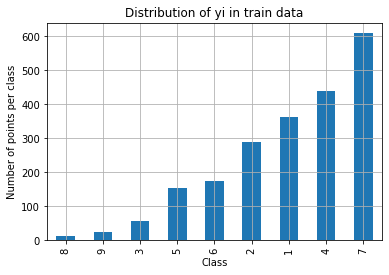

**************************************************


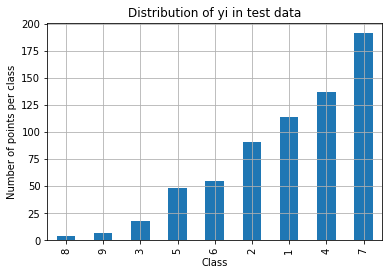

**************************************************


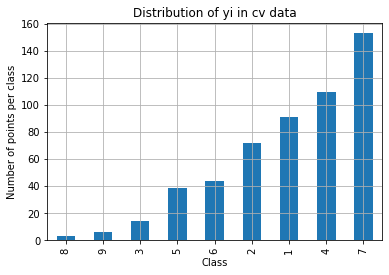

In [14]:
train_class_distribution=X_train['Class'].value_counts().sort_values()
#Plotting the distribution of yi in train data
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


print('*'*50)

test_class_distribution=X_test['Class'].value_counts().sort_values()
#Plotting the distribution of yi in test data
my_colors='rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

print('*'*50)

cv_class_distribution=X_cv['Class'].value_counts().sort_values()
#Plotting the distribution of yi in test data
my_colors = 'rGBkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()


**Confusion Matrix, Precision, Re-call :**

In [0]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix
  A = confusion_matrix(y_test,y_pred)
  #Precision matrix
  B = (((A.T)/(A.sum(axis=1))).T)
  #Recall matrix
  C = (A/A.sum(axis=0))

  labels = [1,2,3,4,5,6,7,8,9]
  #Plot the consuion matrix
  print("-"*20,"Confusion matrix","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()

  #Plot the precision matrix
  print("-"*20,"Precision matrix (Column Sum = 1)","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()

  #Plot the recall matrix
  print("-"*20,"Recall matrix (Row Sum = 1)","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()

**Univariate analysis in Gene feature:**

In [19]:
#Featurization for Gene feature using Tfidf Vectorizer
gene_vectorizer = TfidfVectorizer(stop_words='english')
train_gene_feature_tfidf = gene_vectorizer.fit_transform(X_train['Gene'])
cv_gene_feature_tfidf = gene_vectorizer.transform(X_cv['Gene'])
test_gene_feature_tfidf = gene_vectorizer.transform(X_test['Gene'])
print(train_gene_feature_tfidf.shape)
print(cv_gene_feature_tfidf.shape)
print(test_gene_feature_tfidf.shape)

(2124, 236)
(532, 236)
(665, 236)


In [20]:
#Tfidf Vectorizer for Variation feature
tfidf = TfidfVectorizer(stop_words="english")
train_var_feature_tfidf = tfidf.fit_transform(X_train['Variation'])
cv_var_feature_tfidf = tfidf.transform(X_cv['Variation'])
test_var_feature_tfidf = tfidf.transform(X_test['Variation'])
print(train_var_feature_tfidf.shape)
print(cv_var_feature_tfidf.shape)
print(test_var_feature_tfidf.shape)

(2124, 1950)
(532, 1950)
(665, 1950)


In [21]:
#Tfidf Vectorizer for Text feature
tfidf = TfidfVectorizer(stop_words="english",min_df=10,max_features=5000)
train_text_feature_tfidf = tfidf.fit_transform(X_train['Text'])
cv_text_feature_tfidf = tfidf.transform(X_cv['Text'])
test_text_feature_tfidf = tfidf.transform(X_test['Text'])
print(train_text_feature_tfidf.shape)
print(cv_text_feature_tfidf.shape)
print(test_text_feature_tfidf.shape)

(2124, 5000)
(532, 5000)
(665, 5000)


In [22]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_tfidf = hstack((train_gene_feature_tfidf,train_var_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_feature_tfidf,cv_var_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_feature_tfidf,test_var_feature_tfidf))
print("Shape of Gene feature in Train data is :",train_gene_feature_tfidf.shape[0])
print("Shape of Variation feature in Train data is :",train_var_feature_tfidf.shape[0])
print("Shape of Gene and Variation feature in Train data is :",train_gene_var_tfidf.shape[0])

train_x_tfidfCoding = hstack((train_gene_var_tfidf, train_text_feature_tfidf)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_tfidfCoding = hstack((test_gene_var_tfidf, test_text_feature_tfidf)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_tfidfCoding = hstack((cv_gene_var_tfidf, cv_text_feature_tfidf)).tocsr()
cv_y = np.array(list(X_cv['Class']))

Shape of Gene feature in Train data is : 2124
Shape of Variation feature in Train data is : 2124
Shape of Gene and Variation feature in Train data is : 2124


In [0]:
#Oversampling of "Gene" feature using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE('minority',random_state=42)
train_x_tfidfCoding, y_train = sm.fit_sample(train_x_tfidfCoding, y_train)

In [24]:
print("Tfidf encoding features :")
print("(number of data points * number of features) in train data = ", train_x_tfidfCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidfCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidfCoding.shape)

Tfidf encoding features :
(number of data points * number of features) in train data =  (2721, 7186)
(number of data points * number of features) in test data =  (665, 7186)
(number of data points * number of features) in cross validation data = (532, 7186)


In [40]:
from sklearn.tree import DecisionTreeClassifier
depth=[1, 5, 10, 50, 100, 500, 100]
min_split=[5, 10, 100, 500]

for i in min_split:
  cv_log_error = []
  for j in depth:
    clf=DecisionTreeClassifier(criterion='gini',splitter='best',min_samples_split=i,max_features='auto',max_depth=j,random_state=44)
    clf.fit(train_x_tfidfCoding,y_train)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_tfidfCoding,y_train)
    predicted_y=sig_clf.predict_proba(cv_x_tfidfCoding)
    cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  #print(cv_log_error)
  best_j_error = np.argmin(cv_log_error)
  best_j = depth[best_j_error]
  log_error = cv_log_error[best_j_error]
  print("For the min_split value ",i," and the best depth is :",best_j, "and it's log_loss error is ",(np.around(log_error,3)))
#print(best_j_error)

For the min_split value  5  and the best depth is : 50 and it's log_loss error is  1.275
For the min_split value  10  and the best depth is : 50 and it's log_loss error is  1.266
For the min_split value  100  and the best depth is : 10 and it's log_loss error is  1.404
For the min_split value  500  and the best depth is : 10 and it's log_loss error is  1.64


In [41]:
#Testing with the best hyperparameters
#From above observations we can conclude that the min_split value is 10 and depth is 50 because it's having the lowest log_loss value

clf=DecisionTreeClassifier(criterion='gini',splitter='best',min_samples_split=10,max_features='auto',max_depth=50,random_state=44)
clf.fit(train_x_tfidfCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidfCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_tfidfCoding)
print("For the min_split value 10 and the best depth is 50 and it's log_loss error is",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y1 = sig_clf.predict_proba(cv_x_tfidfCoding)
print("For the min_split value 10 and the best depth is 50 and it's log_loss error is",log_loss(y_cv, predict_y1, labels=clf.classes_, eps=1e-15))
predict_y2 = sig_clf.predict_proba(test_x_tfidfCoding)
print("For the min_split value 10 and the best depth is 50 and it's log_loss error is",log_loss(y_test, predict_y2, labels=clf.classes_, eps=1e-15))


For the min_split value 10 and the best depth is 50 and it's log_loss error is 0.6872609165204442
For the min_split value 10 and the best depth is 50 and it's log_loss error is 1.2656295838243623
For the min_split value 10 and the best depth is 50 and it's log_loss error is 1.367133277763539


In [0]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

Log loss : 1.367133277763539
Number of mis-classified points : 0.45413533834586467
-------------------- Confusion matrix --------------------


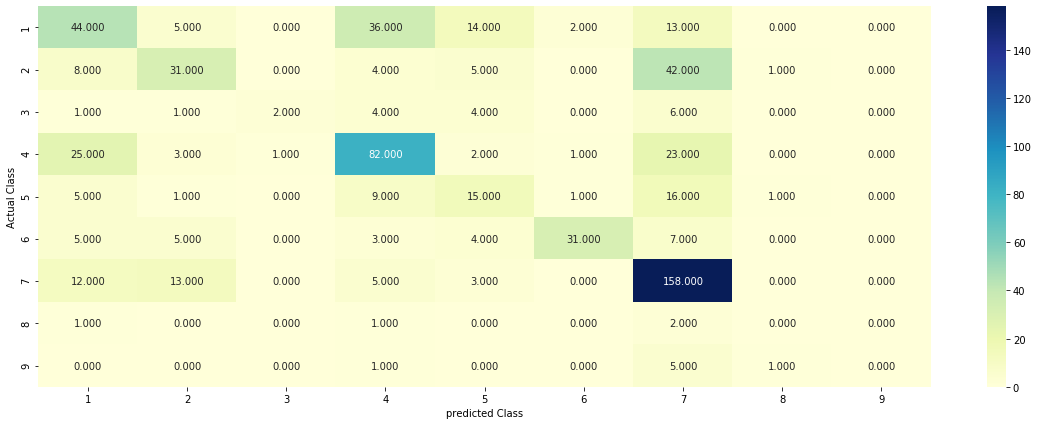

-------------------- Precision matrix (Column Sum = 1) --------------------


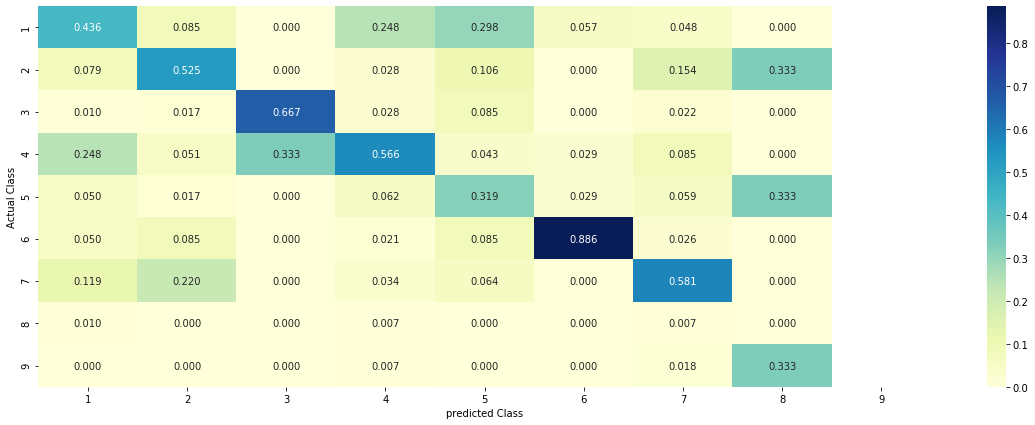

-------------------- Recall matrix (Row Sum = 1) --------------------


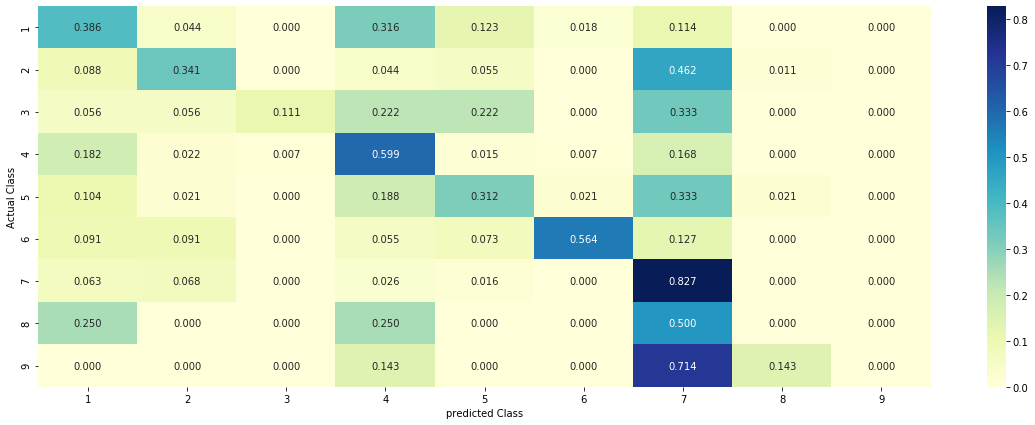

In [43]:
#Testing with best parameters
clf=DecisionTreeClassifier(criterion='gini',splitter='best',min_samples_split=10,max_features='auto',max_depth=50,random_state=44)
predict_and_plot_confusion_matrix(train_x_tfidfCoding, y_train, test_x_tfidfCoding, y_test, clf)

Using decision tree we observed that the log_loss value for test data is around 1.37